In [85]:
import json, os, pathlib as p
import nibabel as nib
import numpy as np
from monai.networks.nets import UNet
from preprocessing import create_LR_img, scale_to_reference_img, pad_to_shape, extract_3D_patches, reconstruct_from_patches
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import TrainDataset
from torch.utils.data import DataLoader
import pickle

In [97]:

#Find data
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))

#Use 70% of data for training, 20% for validation, 10% for testing
train_t1_files = t1_files[:50]
train_t2_files = t2_files[:50]
val_t1_files = t1_files[50:64]
val_t2_files = t2_files[50:64]
test_t1_files = t1_files[64:]
test_t2_files = t2_files[64:]

#Load reference image (T1w)
ref_img = nib.load(t1_files[0])

#Use 70% of data for training
print(round(len(t1_files)*0.7), len(train_t1_files), len(val_t2_files))

50 50 14


In [98]:
#OUTPUT: T2 HR IMAGES
output_images = []
for i in range(len(val_t2_files)):
    hr_t2 = nib.load(val_t2_files[i])
    hr_t2_data = hr_t2.get_fdata()
    hr_t2 = scale_to_reference_img(hr_t2, ref_img)
    print(f"Loaded and scaled image {i+1}/{len(val_t2_files)}")
    #zero pad to fit model input size
    hr_t2_data, new_affine = pad_to_shape(hr_t2.get_fdata(), (192, 224 , 192), hr_t2.affine)
    hr_t2 = nib.Nifti1Image(hr_t2_data, new_affine)
    
    output_images.append(hr_t2)


Loaded and scaled image 1/14
Loaded and scaled image 2/14
Loaded and scaled image 3/14
Loaded and scaled image 4/14
Loaded and scaled image 5/14
Loaded and scaled image 6/14
Loaded and scaled image 7/14
Loaded and scaled image 8/14
Loaded and scaled image 9/14
Loaded and scaled image 10/14
Loaded and scaled image 11/14
Loaded and scaled image 12/14
Loaded and scaled image 13/14
Loaded and scaled image 14/14


In [99]:
#INPUT 1: T2 LR IMAGES
input1_images = []
for i in range(len(val_t2_files)):
    lr_t2_data = create_LR_img(output_images[i].get_fdata(), scale_factor=2)
    lr_t2 = nib.Nifti1Image(lr_t2_data, output_images[i].affine)
    lr_t2 = scale_to_reference_img(lr_t2, ref_img)
    #zero pad to fit model input size
    padded_lr_t2, new_affine = pad_to_shape(lr_t2.get_fdata(), (192, 224 , 192), lr_t2.affine)
    lr_t2 = nib.Nifti1Image(padded_lr_t2, new_affine)
    input1_images.append(lr_t2)



In [100]:
#INPUT 2: T1 HR IMAGES
input2_images = []
for i in range(len(val_t1_files)):
    hr_t1 = nib.load(val_t1_files[i])
    hr_t1_data = hr_t1.get_fdata()
    hr_t1 = scale_to_reference_img(hr_t1, ref_img)
    #zero pad to fit model input size
    hr_t1_data_padded, new_affine = pad_to_shape(hr_t1_data, (192, 224 , 192), hr_t1.affine)
    hr_t1 = nib.Nifti1Image(hr_t1_data_padded, new_affine)
    input2_images.append(hr_t1)




In [101]:
#Extract 3D patches
patch_size = (64, 64, 64)
stride = (32, 32, 32)

#OUTPUT patches
output_patches = []
for i in range(len(output_images)):
    patches = extract_3D_patches(output_images[i].get_fdata(), patch_size, stride)
    print(f"Extracted patches from output image {i+1}/{len(output_images)}")
    output_patches.extend(patches)

#INPUT1 patches
input1_patches = []
for i in range(len(input1_images)):
    patches = extract_3D_patches(input1_images[i].get_fdata(), patch_size, stride)
    input1_patches.extend(patches)  

#INPUT2 patches
input2_patches = []
for i in range(len(input2_images)):
    patches = extract_3D_patches(input2_images[i].get_fdata(), patch_size, stride)
    print(f"Extracted patches from input2 image {i+1}/{len(input2_images)}")
    input2_patches.extend(patches)



Extracted patches from output image 1/14
Extracted patches from output image 2/14
Extracted patches from output image 3/14
Extracted patches from output image 4/14
Extracted patches from output image 5/14
Extracted patches from output image 6/14
Extracted patches from output image 7/14
Extracted patches from output image 8/14
Extracted patches from output image 9/14
Extracted patches from output image 10/14
Extracted patches from output image 11/14
Extracted patches from output image 12/14
Extracted patches from output image 13/14
Extracted patches from output image 14/14
Extracted patches from input2 image 1/14
Extracted patches from input2 image 2/14
Extracted patches from input2 image 3/14
Extracted patches from input2 image 4/14
Extracted patches from input2 image 5/14
Extracted patches from input2 image 6/14
Extracted patches from input2 image 7/14
Extracted patches from input2 image 8/14
Extracted patches from input2 image 9/14
Extracted patches from input2 image 10/14
Extracted 

In [102]:
#Save patches as numpy arrays

#OUTPUT patches - HR T2
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T2"/"output_patches.pkl", "wb") as f:
    pickle.dump(output_patches, f)

#INPUT1 patches - LR T2
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"LR-T2"/"input1_patches.pkl", "wb") as f:
    pickle.dump(input1_patches, f)

#INPUT2 patches - HR T1
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T1"/"input2_patches.pkl", "wb") as f:
    pickle.dump(input2_patches, f)




In [92]:
with open(p.Path.home()/"data"/"patch-dataset"/"train"/"HR-T2"/"output_patches.pkl", "rb") as f:
    output_patches = pickle.load(f)

with open(p.Path.home()/"data"/"patch-dataset"/"train"/"LR-T2"/"input1_patches.pkl", "rb") as f:
    input1_patches = pickle.load(f)

with open(p.Path.home()/"data"/"patch-dataset"/"train"/"HR-T1"/"input2_patches.pkl", "rb") as f:
    input2_patches = pickle.load(f)


<OrthoSlicer3D: (64, 64, 64)>

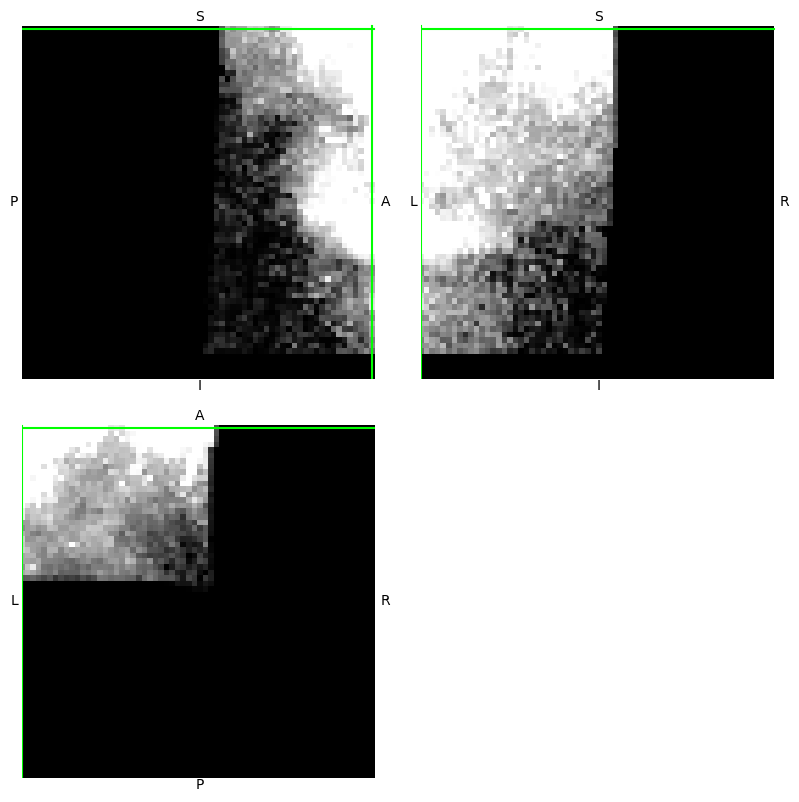

In [93]:
dataset = TrainDataset(input1_patches, input2_patches, output_patches)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [94]:
net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

In [95]:
# 1. Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# 2. Training loop
num_epochs = 5
device = torch.device("cpu")  # or "cuda" if available and supported

net.to(device)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for batch in dataloader:
        # Unpack your batch
        input1, input2, target = batch
        # Stack inputs along channel dimension
        inputs = torch.stack([input1, input2], dim=1).float().to(device)  # (B, 2, 64, 64, 64)
        target = target.unsqueeze(1).float().to(device)  # (B, 1, 64, 64, 64)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 1265.2874
Epoch 2/5, Loss: 1011.6983
Epoch 3/5, Loss: 812.3854
Epoch 4/5, Loss: 652.7391
Epoch 5/5, Loss: 518.7757


In [ ]:
#test model

#OUTPUT patches
test_output_patches = []
patches = extract_3D_patches(output_images[0].get_fdata(), patch_size, stride)
test_output_patches.extend(patches)
print(len(test_output_patches))

#INPUT1 patches
test_input1_patches = []
patches = extract_3D_patches(input1_images[0].get_fdata(), patch_size, stride)
test_input1_patches.extend(patches)
print(len(test_input1_patches)) 

#INPUT2 patches
test_input2_patches = []
patches = extract_3D_patches(input2_images[0].get_fdata(), patch_size, stride)
test_input2_patches.extend(patches)
print(len(test_input2_patches)) 

150
150
150


In [105]:
test_output_patches = output_patches[:150]
test_input1_patches = input1_patches[:150]
test_input2_patches = input2_patches[:150]


In [106]:


net.eval()
all_outputs = []
with torch.no_grad():
    for i in range(len(test_output_patches)):
        input1 = torch.tensor(test_input1_patches[i]).float()
        input2 = torch.tensor(test_input2_patches[i]).float()
        inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 64, 64, 64)
        output = net(inputs)
        all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)

# Reconstruct the image from patches
reconstructed = reconstruct_from_patches(all_outputs, (192, 224, 192), stride)


<OrthoSlicer3D: (192, 224, 192)>

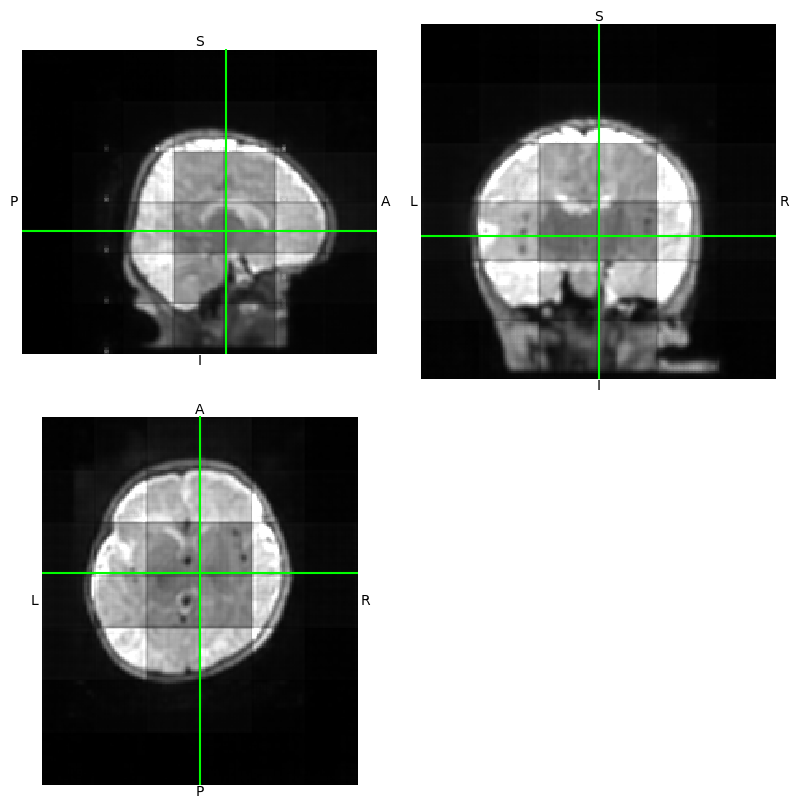

In [107]:
#convert to nifti and save
reconstructed_img = nib.Nifti1Image(reconstructed, output_images[4].affine)
reconstructed_img.orthoview()

<OrthoSlicer3D: (192, 224, 192)>

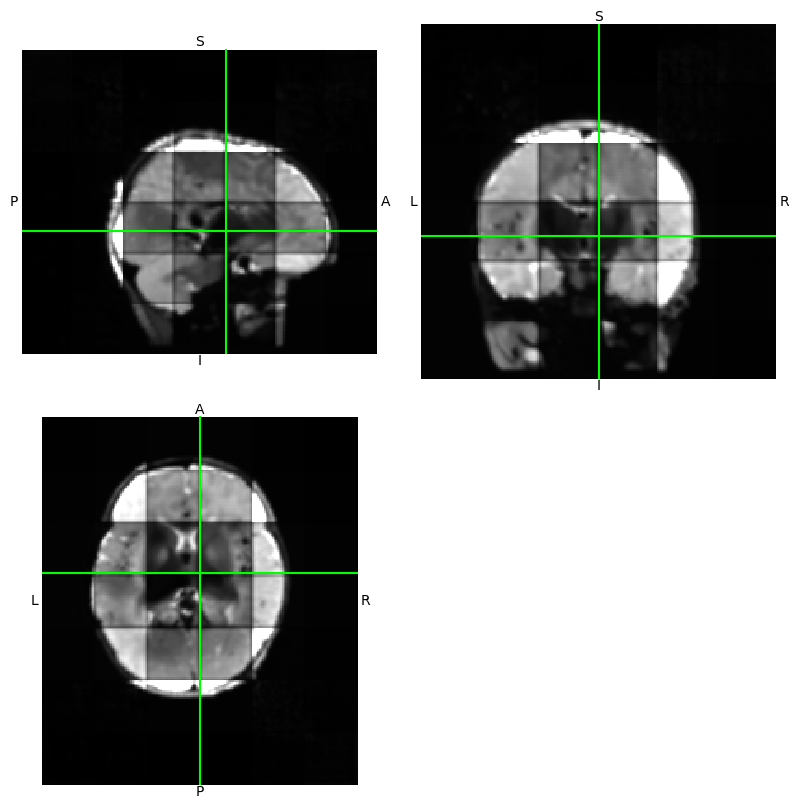

In [77]:
reconstructed_img = nib.Nifti1Image(reconstructed, output_images[4].affine)
reconstructed_img.orthoview()

In [ ]:

# Convert patches to tensors

input1_tensor = torch.stack([torch.tensor(patch) for patch in input1_patches])
input2_tensor = torch.stack([torch.tensor(patch) for patch in input2_patches])
output_tensor = torch.stack([torch.tensor(patch) for patch in output_patches])

inputs = torch.stack([input1_tensor, input2_tensor], dim=1)  # shape: (N, 2, 64, 64, 64)
output = output_tensor.unsqueeze(1)  # Now shape: (N, 1, 64, 64, 64)

print(inputs.shape, output.shape)  # Should be (N, 64, 64, 64)


In [ ]:
output = net(inputs.float())

In [ ]:

#save one patch as nifti for visualization

#patch_img = nib.Nifti1Image(patches[0], new_affine)
#patch_img.orthoview()

#reconstruct image from patches
rec = reconstruct_from_patches(patches, padded_lr_t2.shape, stride)
rec_img = nib.Nifti1Image(rec, new_affine)
#rec_img.orthoview()


In [47]:
#lr_t2_data[0:32, 0:32, 0:32]
#nib.Nifti1Image(lr_t2_data[0:64, 0:64, 0:64], lr_t2.affine).orthoview()
print(len(output_images))
len(output_patches)

4


600